In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import tensorflow 
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



In [4]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model
import itertools

from tensorflow.keras.preprocessing import image

In [5]:
# function to get count of images
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count += len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [6]:
train_dir ="F:/machinelearning/face-mask-dcb/mask-transferlearning/DCBnewimagecrop/train"
val_dir="F:/machinelearning/face-mask-dcb/mask-transferlearning/DCBnewimagecrop/val"
#train_dir ="mask-transferlearning/ImageCrop/train"
#val_dir="mask-transferlearning/ImageCrop/val

In [7]:
train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))

print(num_classes,"Classes")
print(train_samples,"Train images")

13 Classes
12480 Train images



train_dir ="mask-transferlearning/ImageCrop/train"
val_dir="mask-transferlearning/ImageCrop/val"

In [8]:
# Preprocessing data.
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [9]:
# set height and width and color of input image.
img_width,img_height =224,224
input_shape=(img_width,img_height,3)
batch_size =32
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)

Found 12480 images belonging to 13 classes.


In [10]:
# validation data.
validation_generator = val_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width),batch_size=batch_size)

Found 1560 images belonging to 13 classes.


In [11]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
'''baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))'''
#base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

base_model.summary()

9412608/9406464 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

#nclass = 13
'''base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(13, 
                    activation='softmax'))

model = add_model

model.summary()'''

In [12]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = base_model.output   #base_model
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(13, activation="softmax")(headModel)


In [13]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=base_model.input, outputs=headModel)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [15]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in base_model.layers:
    layer.trainable = False

In [16]:
INIT_LR = 0.001
EPOCHS = 25
BS = 32

In [17]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=['acc'])
# train the head of the network
print("[INFO] training head...")

[INFO] compiling model...
[INFO] training head...


model.compile(loss='categorical_crossentropy',optimizer=tensorflow.keras.optimizers.Adamax(lr=0.001),metrics=['acc'])

checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath='model-{epoch:03d}.ckpt',
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True, 
    verbose=0)

#history = model.fit(train_generator, validation_data = validation_generator,workers=10,epochs=20, callbacks=[checkpoint])


In [18]:
history = model.fit(train_generator, validation_data = validation_generator,epochs=25)

Epoch 1/25
390/390 [==============================] - 1558s 4s/step - loss: 0.7381 - acc: 0.7704 - val_loss: 0.1247 - val_acc: 0.9776
Epoch 2/25
390/390 [==============================] - 1355s 3s/step - loss: 0.2069 - acc: 0.9385 - val_loss: 0.0644 - val_acc: 0.9840
Epoch 3/25
390/390 [==============================] - 1364s 3s/step - loss: 0.1213 - acc: 0.9651 - val_loss: 0.0370 - val_acc: 0.9897
Epoch 4/25
390/390 [==============================] - 1371s 4s/step - loss: 0.0951 - acc: 0.9704 - val_loss: 0.0377 - val_acc: 0.9910
Epoch 5/25
390/390 [==============================] - 1697s 4s/step - loss: 0.0856 - acc: 0.9740 - val_loss: 0.0278 - val_acc: 0.9942
Epoch 6/25
390/390 [==============================] - 1269s 3s/step - loss: 0.0697 - acc: 0.9788 - val_loss: 0.0187 - val_acc: 0.9936
Epoch 7/25
390/390 [==============================] - 1292s 3s/step - loss: 0.0664 - acc: 0.9792 - val_loss: 0.0173 - val_acc: 0.9942
Epoch 8/25
390/390 [==============================] - 1308s 3s

In [19]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("facemask_detector_mobilenet.model", save_format="h5")

[INFO] saving mask detector model...


In [20]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


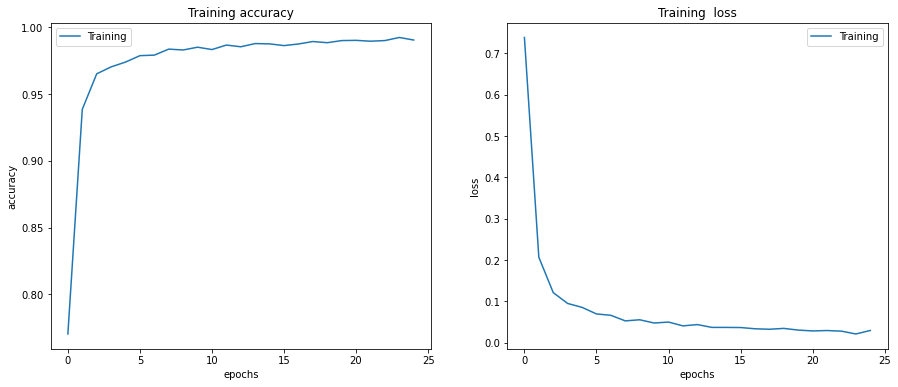

In [21]:
# PLOT LOSS AND ACCURACY
acc = history.history['acc']

loss = history.history['loss']


plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(acc, label='Training')

plt.title('Training accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(122)
plt.plot(loss, label='Training')

plt.title('Training  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

<Figure size 432x288 with 0 Axes>

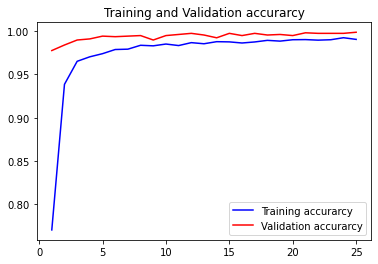

<Figure size 432x288 with 0 Axes>

In [24]:
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
#plt.ylim(0.75, 1)
plt.figure()

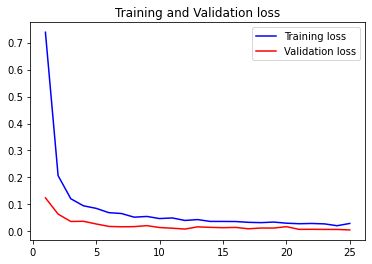

In [25]:
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
#model.save('facemaskinceptionV3-model.h5')

In [26]:
# Get classes of model trained on
classes = train_generator.class_indices 
classes

{'Achuthsankar': 0,
 'Alwin': 1,
 'Arya': 2,
 'Aryason': 3,
 'Ashwini': 4,
 'Biji': 5,
 'Chithra': 6,
 'Rani': 7,
 'Rashmi': 8,
 'Shanitha': 9,
 'Sheeba': 10,
 'Silpa': 11,
 'Sunitha': 12}

In [28]:
#test_dir="mask-transferlearning//ImageCrop/test"
test_dir="F:/machinelearning/face-mask-dcb/mask-transferlearning/DCBnewimagecrop/test"

img_width,img_height =224,224
input_shape=(img_width,img_height,3)
batch_size =32

test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=False,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)

Found 1560 images belonging to 13 classes.


In [29]:
score,accuracy =model.evaluate_generator(test_generator,verbose=1)
print("Test loss is {}".format(score))
print("Test accuracy is {}".format(accuracy))

49/49 [==============================] - 146s 3s/step - loss: 0.0103 - acc: 0.9955
Test loss is 0.010312693193554878
Test accuracy is 0.995512843132019


In [30]:

#test_steps_per_epoch = numpy.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict_generator(test_generator)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

In [31]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  

In [32]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

              precision    recall  f1-score   support

Achuthsankar       1.00      1.00      1.00       120
       Alwin       1.00      1.00      1.00       120
        Arya       1.00      0.99      1.00       120
     Aryason       1.00      1.00      1.00       120
     Ashwini       0.96      0.99      0.98       120
        Biji       0.99      1.00      1.00       120
     Chithra       1.00      0.96      0.98       120
        Rani       1.00      1.00      1.00       120
      Rashmi       1.00      1.00      1.00       120
    Shanitha       1.00      1.00      1.00       120
      Sheeba       0.99      1.00      1.00       120
       Silpa       1.00      1.00      1.00       120
     Sunitha       1.00      1.00      1.00       120

    accuracy                           1.00      1560
   macro avg       1.00      1.00      1.00      1560
weighted avg       1.00      1.00      1.00      1560



In [33]:
def plot_confusion_matrix(true_classes, predicted_classes, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

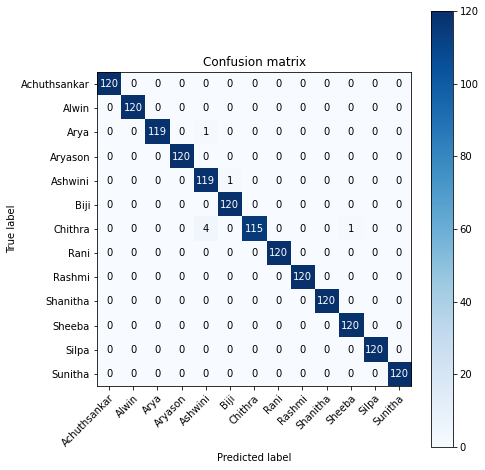

In [34]:
classes = test_generator.class_indices 
# Plotting non-normalized confusion matrix
plot_confusion_matrix(true_classes, predicted_classes, classes, title='Confusion matrix')

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

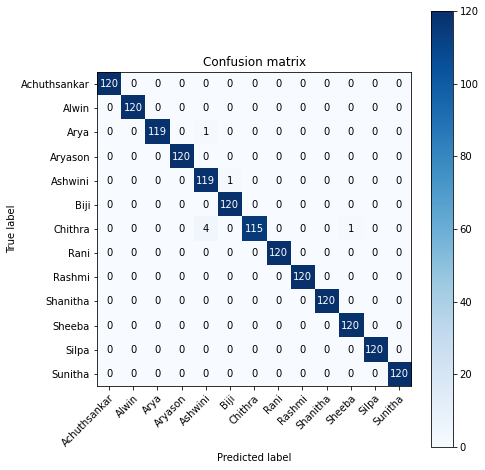

In [35]:
classes = test_generator.class_indices 
# Plotting non-normalized confusion matrix
plot_confusion_matrix(true_classes, predicted_classes, classes, title='Confusion matrix')

In [36]:
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

#Classes = ["Achuthsankar","Alwin", "Arya", "Aswini", "Biji", "Rani", "Rashmi", "Shanitha", "Sheeba","Silpa","Sunitha" ]
Classes =["Achuthsankar", "Alwin", "Arya", "Aryason", "Ashwini", "Biji", "Chithra", "Rani",  "Rashmi",  "Shanitha",  "Sheeba",  "Silpa",  "Sunitha"]
#path = 'mask-transferlearning/ImageCrop/test1/'
#path = r'C:\Users\DCB\Downloads\Chithra\DCB-face-detection\DCBnewimagecrop\test'
path = 'F:/machinelearning/face-mask-dcb/mask-transferlearning/ImageCrop/test1/'
filenames = os.listdir(path) 
print(path)




F:/machinelearning/face-mask-dcb/mask-transferlearning/ImageCrop/test1/


for dirpath, dirs, files in os.walk(r'C:\Users\DCB\Downloads\Chithra\DCB-face-detection\DCBnewimagecrop\test'): 
    for filename in files:
        fname = os.path.join(dirpath,filename)
        print(fname)

DIR = r"C:\Users\DCB\Downloads\Chithra\DCB-face-detection\DCBnewimagecrop\test"
#DIRECTORY = "dataset"
CATEGORIES = ["Achuthsankar", "Alwin", "Arya", "Aryason", "Ashwini", "Biji", "Chithra", "Rani",  "Rashmi",  "Shanitha",  "Sheeba",  "Silpa",  "Sunitha"]
for category in CATEGORIES:
    path1 = os.path.join(DIR, category)
    print(path1)
    

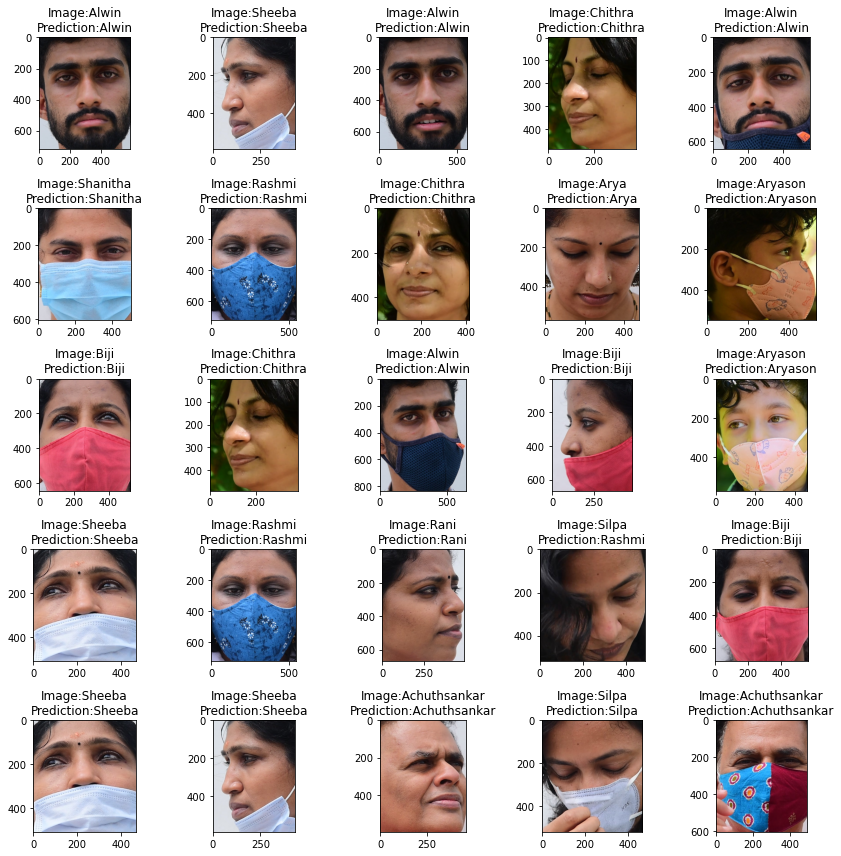

In [39]:
plt.figure(figsize=(12,12))
for i in range(25):
  plt.subplot(5,5,i+1)
  filename = random.choice(filenames)
  filename_split = filename.split('.')[0]
  result = model.predict([prepare(path + filename)])
  pred_classes = np.argmax(result, axis=1)
  testimage = image.load_img(path + filename)
  plt.imshow(testimage)
  plt.title("Image:" + filename_split + "\nPrediction:" + Classes[int(pred_classes[0])])

plt.tight_layout()
plt.show()             
                            

In [40]:
from itertools import cycle

from sklearn.metrics import roc_curve, auc

from sklearn.multiclass import OneVsRestClassifier

from scipy import interp
from sklearn.metrics import roc_auc_score

In [41]:
# Compute ROC curve and ROC area for each class
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_classes = 13

for i in range(n_classes):    
    fpr[i], tpr[i], thresh[i] = roc_curve(true_classes, predictions[:,i], pos_label=i)
 

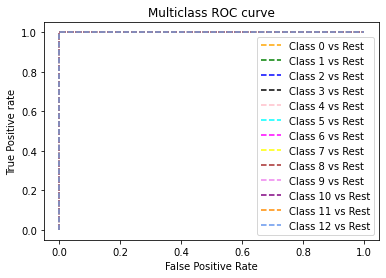

In [42]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[0], tpr[0], linestyle='--',color='black', label='Class 3 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='pink', label='Class 4 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='cyan', label='Class 5 vs Rest')
plt.plot(fpr[0], tpr[0], linestyle='--',color='magenta', label='Class 6 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='yellow', label='Class 7 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='brown', label='Class 8 vs Rest')
plt.plot(fpr[0], tpr[0], linestyle='--',color='violet', label='Class 9 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='purple', label='Class 10 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='darkorange', label='Class 11 vs Rest')
plt.plot(fpr[0], tpr[0], linestyle='--',color='cornflowerblue', label='Class 12 vs Rest')
#'aqua', 'darkorange', 'cornflowerblue'

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  

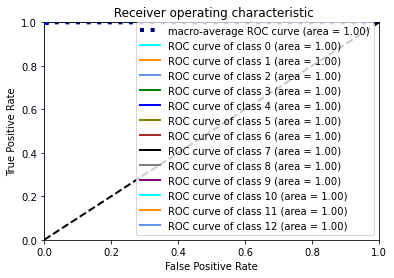

In [44]:
roc_auc = dict()
for i in range(n_classes):
    roc_auc[i] = auc(fpr[i], tpr[i])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw=2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'blue', 'olive', 'brown', 'black', 'gray', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
